# Load dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy
from scipy.signal import savgol_filter
from scipy.spatial.distance import pdist,squareform
from scipy.stats import mannwhitneyu
import torch
import torch.nn.functional as F
import math
from matplotlib import pyplot as plt
import umap

from models import SimpleEncoder,Decoder,PriorDiscriminator,LocalDiscriminator
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

from IPython.display import clear_output
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

# Load Data

In [4]:
# Gex data 
cmap = pd.read_csv('../preprocessing/preprocessed_data/baselineCell/cmap_all_baselines_q1.csv',index_col=0)
gene_size = len(cmap.columns)
X = cmap.values
display(cmap)

,16,23,25,30,39,47,102,128,142,154,...,94239,116832,124583,147179,148022,200081,200734,256364,375346,388650
OFL001_A549_96H:G15,1.854175,1.868439,-0.140405,-0.278911,0.396597,0.334116,0.473704,-0.565553,1.372410,1.181299,...,1.252141,-0.291923,1.193942,0.978987,2.381282,-1.065447,1.174847,-0.885704,0.879203,0.216700
OFL001_MCF7_96H:J10,0.081511,0.651525,-0.205014,0.054704,0.726742,-0.126017,0.200712,0.915557,0.780285,0.007211,...,0.341261,0.405606,-0.054713,0.264261,-0.096964,0.752965,-0.249324,-1.176310,0.282062,-0.212717
ABY001_NCIH1975_XH:CMAP-000:-666:3,0.543459,1.647965,-1.731661,0.319534,1.078192,0.602553,0.323291,0.787790,0.888264,1.532468,...,0.704732,-1.326966,1.433667,-0.037051,1.016276,-0.481035,1.061352,1.616178,1.540468,-0.958139
ZTO.XPR001_THP1_408H:CMAP-000:-666,-0.054865,-0.085794,-0.319447,0.180520,0.124284,-0.117936,-0.267994,0.429114,-0.144781,0.190815,...,-0.114969,0.308555,0.055869,-0.450732,-0.394338,0.029793,0.046924,-0.231632,-0.186150,-0.309360
MOA001_A549_24H:N01,0.401776,1.197786,0.946556,0.794930,0.662958,0.473484,1.335021,0.338371,0.300303,0.690938,...,0.020668,0.171860,0.862337,0.525409,-0.029795,-0.263026,0.271724,0.934595,0.552001,-0.711617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL001_HT29_24H:CMAP-000:-666,0.038320,-0.426547,0.183131,0.450992,-0.414180,-0.619587,-0.318295,0.066966,-0.618409,0.539847,...,0.085557,0.018541,0.174058,-0.101450,-0.279539,-0.303862,0.019368,1.111968,0.387193,-0.770082
DOSVAL001_HA1E_24H:CMAP-000:-666,0.319681,-0.182241,0.689418,0.542491,-0.124395,0.252069,-0.348502,0.145006,-0.018389,0.190280,...,-0.048443,0.188158,0.422073,0.123565,0.097611,-0.003442,0.924158,-0.212382,0.166562,0.142994
DOSVAL001_A375_24H:CMAP-000:-666,0.091151,-0.007194,0.360459,0.430177,-0.443078,-0.370296,-0.450974,0.616529,0.258591,0.111886,...,-0.571711,0.084373,0.240619,-0.372428,-0.168089,-0.137313,0.157594,0.256362,0.080780,-0.065995
DOSVAL001_HEPG2_24H:CMAP-000:-666,-0.276361,-0.321295,0.412983,0.040179,-0.144093,-0.374313,-0.488024,0.273988,-0.278131,-0.075510,...,-0.440074,0.220422,-0.144075,-0.162023,-0.328652,-0.300582,0.469960,-0.533808,0.158130,-0.492051


# Train autoencoder with all q1 controls

In [5]:
model_params = {'encoder_hiddens':[640,384],
                'latent_dim': 292,
                'decoder_hiddens':[384,640],
                'dropout_decoder':0.2,
                'dropout_encoder':0.1,
                'encoder_activation':torch.nn.ELU(),
                'decoder_activation':torch.nn.ELU(),
                'lr':0.001,
                'schedule_step':200,
                'gamma':0.5,
                'batch_size':128,
                'epochs':500,
                'no_folds':10,
                'enc_l2_reg':0.01,
                'dec_l2_reg':0.01,
                'autoencoder_wd': 0.}

In [6]:
bs=model_params['batch_size']
k_folds=model_params['no_folds']
NUM_EPOCHS=model_params['epochs']
kfold=KFold(n_splits=k_folds,shuffle=True)

In [7]:
dataset = torch.utils.data.TensorDataset(torch.tensor(X).float())

Fold=0, Epoch=1/500, loss=628.4364, Pearson`s r=0.3593
Fold=0, Epoch=101/500, loss=230.4944, Pearson`s r=0.7575
Fold=0, Epoch=201/500, loss=217.2103, Pearson`s r=0.7772
Fold=0, Epoch=301/500, loss=196.5769, Pearson`s r=0.8076
Fold=0, Epoch=401/500, loss=196.0548, Pearson`s r=0.8070
Fold=0, Epoch=500/500, loss=217.0013, Pearson`s r=0.8155
Validation performance: Fold=0, Pearson`s r=0.8063
Fold=1, Epoch=1/500, loss=575.0684, Pearson`s r=0.3447
Fold=1, Epoch=101/500, loss=241.0442, Pearson`s r=0.7342
Fold=1, Epoch=201/500, loss=219.8844, Pearson`s r=0.7930
Fold=1, Epoch=301/500, loss=207.7966, Pearson`s r=0.7703
Fold=1, Epoch=401/500, loss=199.3321, Pearson`s r=0.7780
Fold=1, Epoch=500/500, loss=196.1797, Pearson`s r=0.7780
Validation performance: Fold=1, Pearson`s r=0.8126
Fold=2, Epoch=1/500, loss=486.4526, Pearson`s r=0.3202
Fold=2, Epoch=101/500, loss=243.7110, Pearson`s r=0.7464
Fold=2, Epoch=201/500, loss=222.2343, Pearson`s r=0.7854
Fold=2, Epoch=301/500, loss=227.8018, Pearson`s r

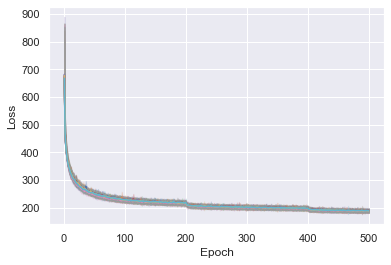

In [8]:
valPear = []
trainPear = []
for fold,(train_idx,val_idx) in enumerate(kfold.split(dataset)):
    
    X_train = torch.tensor(X[train_idx,:]).float().to(device)
    X_val = torch.tensor(X[val_idx,:]).float().to(device)
    N = X_train.shape[0]
    
    decoder = Decoder(model_params['latent_dim'],model_params['decoder_hiddens'],gene_size,
                      dropRate=model_params['dropout_decoder'], 
                      activation=model_params['decoder_activation']).to(device)
    encoder = SimpleEncoder(gene_size,model_params['encoder_hiddens'],model_params['latent_dim'],
                            dropRate=model_params['dropout_encoder'], 
                            activation=model_params['encoder_activation']).to(device)
    
    allParams = list(decoder.parameters()) + list(encoder.parameters())
    optimizer = torch.optim.Adam(allParams, lr=model_params['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=model_params['schedule_step'],
                                                gamma=model_params['gamma'])
    trainLoss = []
    trainLossSTD = []
    for e in range(NUM_EPOCHS):
        encoder.train()
        decoder.train()
        
        trainloader = getSamples(N, bs)
        trainLoss_ALL = []
        for dataIndex in trainloader:
            
            dataIn = X_train[dataIndex,:]
            
            optimizer.zero_grad()
            Xhat = decoder(encoder(dataIn))
            L2Loss = encoder.L2Regularization(model_params['enc_l2_reg']) + decoder.L2Regularization(model_params['dec_l2_reg'])
            loss = torch.mean(torch.sum((Xhat - dataIn)**2,dim=1)) + L2Loss
            
            loss.backward()
            optimizer.step()
            
            pear = pearson_r(Xhat.detach(), dataIn.detach())
            trainLoss_ALL.append(loss.item())
        if e%100==0:
            outString = 'Fold={:.0f}'.format(fold)
            outString += ', Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', Pearson`s r={:.4f}'.format(pear.item())
            print(outString)
        scheduler.step()
        trainLoss.append(np.mean(trainLoss_ALL))
        trainLossSTD.append(np.std(trainLoss_ALL))
    outString = 'Fold={:.0f}'.format(fold)
    outString += ', Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', Pearson`s r={:.4f}'.format(pear.item())
    print(outString)
    
    encoder.eval()
    decoder.eval()
    
    Xhat = decoder(encoder(X_val))
    pear = pearson_r(Xhat.detach(), X_val.detach())
    
    outString = 'Validation performance: Fold={:.0f}'.format(fold)
    outString += ', Pearson`s r={:.4f}'.format(pear.item())
    print(outString)
    valPear.append(pear.item())
    
    Xhat = decoder(encoder(X_train))
    pear = pearson_r(Xhat.detach(), X_train.detach())
    trainPear.append(pear.item())
    
    plt.plot(range(1,model_params['epochs']+1),np.array(trainLoss))
    curColor = plt.gca().lines[-1].get_color()
    plt.fill_between(range(1,model_params['epochs']+1), 
                    np.array(trainLoss) - np.array(trainLossSTD), 
                    np.array(trainLoss) + np.array(trainLossSTD),
                    color=curColor, alpha=0.2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

In [9]:
results = pd.DataFrame({'r':trainPear,
                        'set':'train'})
results = results.append(pd.DataFrame({'r':valPear,
                        'set':'validation'}))

In [10]:
results
results.to_csv('../results/BaselineCellsAnalysis/ae_results.csv')

MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002)


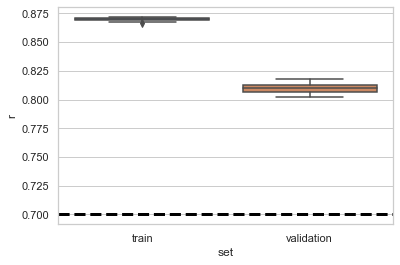

In [13]:
stats_results = mannwhitneyu(np.array(trainPear),np.array(valPear))
print(stats_results)
sns.set_theme(style="whitegrid")
sns.boxplot(data=results,x="set",y = "r")
plt.axhline(y=0.7, color='black', linestyle='--',linewidth=3)
plt.show()

# Train trasnlation model

In [5]:
model_params = {'encoder_1_hiddens':[384,256],
                'encoder_2_hiddens':[384,256],
                'latent_dim': 128,
                'decoder_1_hiddens':[256,384],
                'decoder_2_hiddens':[256,384],
                'dropout_decoder':0.2,
                'dropout_encoder':0.1,
                'encoder_activation':torch.nn.ELU(),
                'decoder_activation':torch.nn.ELU(),
                'state_class_hidden':[256,128,64],
                'state_class_drop_in':0.5,
                'state_class_drop':0.25,
                'no_states':2,
                'encoding_lr':0.001,
                'schedule_step_enc':200,
                'gamma_enc':0.8,
                'batch_size':512,
                'epochs':1000,
                'prior_beta':1.0,
                'no_folds':2,
                'state_class_reg':1e-02,
                'enc_l2_reg':0.001,
                'dec_l2_reg':0.001,
                'lambda_mi_loss':100,
                'cosine_loss': 10,
                'reg_classifier': 10,
                'similarity_reg' : 10.,
                'autoencoder_wd': 0}

In [6]:
bs =  model_params['batch_size']
# k_folds=model_params['no_folds']
NUM_EPOCHS=model_params['epochs']
# kfold=KFold(n_splits=k_folds,shuffle=True)

In [7]:
num_genes = int(0.5*gene_size)
random_iterations = 2

In [ ]:
for cell in ["A549","MCF7","A375","PC3","HT29","VCAP","AGS","ES2","YAPC","BICR6","U251MG"]:
    for n in range(random_iterations):
        genes_1 = np.random.choice(cmap.columns.values, size=num_genes, replace=False)
        genes_2 = np.setdiff1d(cmap.columns.values,genes_1)
        valPear = []
        valPear_1 = []
        valPear_2 = []
        for i in range(model_params['no_folds']):
            trainInfo = pd.read_csv('../preprocessing/preprocessed_data/baselineCell/'+cell+'/train_'+str(i)+'.csv',index_col=0)
            valInfo = pd.read_csv('../preprocessing/preprocessed_data/baselineCell/'+cell+'/train_'+str(i)+'.csv',index_col=0)

            cmap_train = cmap.loc[trainInfo.sig_id,:]
            cmap_val = cmap.loc[valInfo.sig_id,:]
            N = len(cmap_train)

            # Network
            decoder_1 = Decoder(model_params['latent_dim'],model_params['decoder_1_hiddens'],num_genes,
                                dropRate=model_params['dropout_decoder'], 
                                activation=model_params['decoder_activation']).to(device)
            decoder_2 = Decoder(model_params['latent_dim'],model_params['decoder_2_hiddens'],num_genes,
                                dropRate=model_params['dropout_decoder'], 
                                activation=model_params['decoder_activation']).to(device)
            encoder_1 = SimpleEncoder(num_genes,model_params['encoder_1_hiddens'],model_params['latent_dim'],
                                      dropRate=model_params['dropout_encoder'], 
                                      activation=model_params['encoder_activation'],
                                     normalizeOutput=True).to(device)
            encoder_2 = SimpleEncoder(num_genes,model_params['encoder_2_hiddens'],model_params['latent_dim'],
                                          dropRate=model_params['dropout_encoder'], 
                                          activation=model_params['encoder_activation'],
                                     normalizeOutput=True).to(device)
            prior_d = PriorDiscriminator(model_params['latent_dim']).to(device)
            local_d = LocalDiscriminator(model_params['latent_dim'],model_params['latent_dim']).to(device)

            allParams = list(decoder_1.parameters()) + list(encoder_1.parameters())
            allParams = allParams + list(decoder_2.parameters()) + list(encoder_2.parameters())
            allParams = allParams  + list(local_d.parameters())
            allParams = allParams + list(prior_d.parameters())
            optimizer = torch.optim.Adam(allParams, lr=model_params['encoding_lr'])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                        step_size=model_params['schedule_step_enc'],
                                                        gamma=model_params['gamma_enc'])
            trainLoss = []
            trainLossSTD = []
            for e in range(NUM_EPOCHS):
                encoder_1.train()
                decoder_1.train()
                encoder_2.train()
                decoder_2.train()
                prior_d.train()
                local_d.train()

                trainloader = getSamples(N, bs)
                trainLoss_ALL = []
                for dataIndex in trainloader:

                    data_1 = torch.tensor(cmap_train.loc[:,genes_1].values).float()
                    data_1 = data_1[dataIndex,:].to(device)
                    data_2 = torch.tensor(cmap_train.loc[:,genes_1].values).float()
                    data_2 = data_2[dataIndex,:].to(device)
                    
                    conditions = trainInfo.conditionId.values[dataIndex]
                    conditions = np.concatenate((conditions,conditions))
                    size = conditions.size
                    conditions = conditions.reshape(size,1)
                    conditions = conditions == conditions.transpose()
                    conditions = conditions*1
                    mask = torch.tensor(conditions).to(device).detach()
                    pos_mask = mask
                    neg_mask = 1 - mask
                    log_2 = math.log(2.)
                
                    optimizer.zero_grad()
                    
                    z_1 = encoder_1(data_1)
                    z_2 = encoder_2(data_2)
                    
                    #print('Epoch %s'%e)
                    #print(z_1)
                    
                    latent_vectors = torch.cat((z_1, z_2), 0)
                    z_un = local_d(latent_vectors)
                    #z_un_1 = local_d(z_1)
                    #z_un_2 = local_d(z_2)
                    #res_un = torch.matmul(z_un_1, z_un_2.t())
                    res_un = torch.matmul(z_un, z_un.t())
                    
                    #print(res_un)
                    
                    Xhat_1 = decoder_1(z_1)
                    Xhat_2 = decoder_2(z_2)
                    loss_1 = torch.mean(torch.sum((Xhat_1 - data_1)**2,dim=1)) + encoder_1.L2Regularization(model_params['enc_l2_reg']) + decoder_1.L2Regularization(model_params['dec_l2_reg'])
                    loss_2 = torch.mean(torch.sum((Xhat_2 - data_2)**2,dim=1)) +encoder_2.L2Regularization(model_params['enc_l2_reg']) + decoder_2.L2Regularization(model_params['dec_l2_reg'])
                    
                    silimalityLoss = torch.sum(torch.cdist(latent_vectors, latent_vectors) * pos_mask.float()) / pos_mask.float().sum()
                    #silimalityLoss = torch.mean(torch.cdist(z_1, z_2))
                    w1 = latent_vectors.norm(p=2, dim=1, keepdim=True)
                    w2 = latent_vectors.norm(p=2, dim=1, keepdim=True)
                    cosineLoss = torch.mm(latent_vectors, latent_vectors.t()) / (w1 * w2.t()).clamp(min=1e-6)
                    cosineLoss = torch.sum(cosineLoss * pos_mask.float()) / pos_mask.float().sum()
                    #cosineLoss = torch.mean(cosineLoss)

                    p_samples = res_un * pos_mask.float()
                    q_samples = res_un * neg_mask.float()

                    Ep = log_2 - F.softplus(- p_samples)
                    Eq = F.softplus(-q_samples) + q_samples - log_2

                    Ep = (Ep * pos_mask.float()).sum() / pos_mask.float().sum()
                    Eq = (Eq * neg_mask.float()).sum() / neg_mask.float().sum()
                    mi_loss = Eq - Ep
                    #mi_loss = torch.nan_to_num(mi_loss, nan=1e-03)

                    prior = torch.rand_like(torch.cat((z_1, z_2), 0))
                    term_a = torch.log(prior_d(prior)).mean()
                    term_b = torch.log(1.0 - prior_d(torch.cat((z_1, z_2), 0))).mean()
                    prior_loss = -(term_a + term_b) * model_params['prior_beta']
                    
                    loss = loss_1 + loss_2 + model_params[
                        'similarity_reg']*silimalityLoss - model_params[
                        'cosine_loss'] * cosineLoss + prior_loss + model_params['lambda_mi_loss'] * mi_loss
                    #loss = loss_1 + loss_2 + model_params[
                    #    'similarity_reg'] * silimalityLoss + model_params[
                    #    'lambda_mi_loss'] * mi_loss + prior_loss 
                    loss.backward()
                    optimizer.step()
                    
                    #w1 = latent_vectors.norm(p=2, dim=1, keepdim=True)
                    #w2 = latent_vectors.norm(p=2, dim=1, keepdim=True)
                    #cosineLoss = torch.mm(latent_vectors, latent_vectors.t()) / (w1 * w2.t()).clamp(min=1e-6)
                    #cosineLoss = torch.sum(cosineLoss * pos_mask.float()) / pos_mask.float().sum()

                    pear_1 = pearson_r(Xhat_1.detach(), data_1.detach())
                    mse_1 = torch.mean(torch.mean((Xhat_1.detach() - data_1.detach()) ** 2, dim=1))
                    pear_2 = pearson_r(Xhat_2.detach(), data_2.detach())
                    mse_2 = torch.mean(torch.mean((Xhat_2.detach() - data_2.detach()) ** 2, dim=1))
                    trainLoss_ALL.append(loss.item())
                    
                if e%100==0:
                    outString = 'Cell-line : '+cell+', rand_iter {:.0f}/{:.0f}'.format(n + 1, random_iterations)
                    outString += ', Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i + 1, e + 1, NUM_EPOCHS)
                    outString += ', pearson_1={:.4f}'.format(pear_1.item())
                    outString += ', MSE_1={:.4f}'.format(mse_1.item())
                    outString += ', pearson_2={:.4f}'.format(pear_2.item())
                    outString += ', MSE_2={:.4f}'.format(mse_2.item())
                    outString += ', MI Loss={:.4f}'.format(mi_loss.item())
                    outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
                    outString += ', Cosine ={:.4f}'.format(cosineLoss.item())
                    outString += ', silimalityLoss ={:.4f}'.format(silimalityLoss.item())
                    outString += ', loss={:.4f}'.format(loss.item())
                    print(outString)
                scheduler.step()
                trainLoss.append(np.mean(trainLoss_ALL))
                trainLossSTD.append(np.std(trainLoss_ALL))
            outString = 'Cell-line : '+cell+', rand_iter {:.0f}/{:.0f}'.format(n + 1, random_iterations)
            outString += ', Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i + 1, e + 1, NUM_EPOCHS)
            outString += ', pearson_1={:.4f}'.format(pear_1.item())
            outString += ', MSE_1={:.4f}'.format(mse_1.item())
            outString += ', pearson_2={:.4f}'.format(pear_2.item())
            outString += ', MSE_2={:.4f}'.format(mse_2.item())
            outString += ', MI Loss={:.4f}'.format(mi_loss.item())
            outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
            outString += ', Cosine ={:.4f}'.format(cosineLoss.item())
            outString += ', silimalityLoss ={:.4f}'.format(silimalityLoss.item())
            outString += ', loss={:.4f}'.format(loss.item())
            print(outString)

            encoder_1.eval()
            decoder_1.eval()
            encoder_2.eval()
            decoder_2.eval()
            prior_d.eval()
            local_d.eval()
            
            print('Validation performance for cell %s for try %s for split %s'%(cell,n,i))


            X_1 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
            X_2 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
                    
            z_1 = encoder_1(X_1)
            z_2 = encoder_2(X_2)
            Xhat_1 = decoder_1(z_1)
            Xhat_2 = decoder_2(z_2)
            
            pear_1 = pearson_r(Xhat_1.detach(), X_1.detach())
            pear_2 = pearson_r(Xhat_2.detach(), X_2.detach())
            valPear_1.append(pear_1.item())
            valPear_2.append(pear_2.item())

            print('Pearson correlation 1: %s'%pear_1.item())
            print('Pearson correlation 2: %s'%pear_2.item())
    
    
            x_hat_2_equivalent = decoder_2(z_1).detach()
            pearson_2 = pearson_r(x_hat_2_equivalent.detach(), X_2.detach())
            print('Pearson correlation 1 to 2: %s'%pearson_2.item())
            x_hat_1_equivalent = decoder_1(z_2).detach()
            pearson_1 = pearson_r(x_hat_1_equivalent.detach(), X_1.detach())
            print('Pearson correlation 2 to 1: %s'%pearson_1.item())
            
            valPear.append([pearson_2.item(),pearson_1.item()])
            
            torch.save(decoder_1,'../results/BaselineCellsAnalysis/models_AutoTransOp/'+cell+'/decoder_1_fold%s_iter%s.pt'%(i,n))
            torch.save(decoder_2,'../results/BaselineCellsAnalysis/models_AutoTransOp/'+cell+'/decoder_2_fold%s_iter%s.pt'%(i,n))
            torch.save(prior_d,'../results/BaselineCellsAnalysis/models_AutoTransOp/'+cell+'/priorDiscr_fold%s_iter%s.pt'%(i,n))
            torch.save(local_d,'../results/BaselineCellsAnalysis/models_AutoTransOp/'+cell+'/localDiscr_fold%s_iter%s.pt'%(i,n))
            torch.save(encoder_1,'../results/BaselineCellsAnalysis/models_AutoTransOp/'+cell+'/encoder_1_fold%s_iter%s.pt'%(i,n))
            torch.save(encoder_2,'../results/BaselineCellsAnalysis/models_AutoTransOp/'+cell+'/encoder_2_fold%s_iter%s.pt'%(i,n))            
            
        valPear = np.array(valPear)
        df_result = pd.DataFrame({'model_pearson2to1':valPear[:,0],'model_pearson1to2':valPear[:,1],
                          'recon_pear_2':valPear_2 ,'recon_pear_1':valPear_1})
        df_result['cell'] = cell
        df_result['iteration'] = n
        df_result['fold'] = i
        df_result.to_csv('../results/BaselineCellsAnalysis/translation_results.csv')

Cell-line : A549, rand_iter 1/2, Split 1: Epoch=1/1000, pearson_1=0.0081, MSE_1=1.2559, pearson_2=0.0012, MSE_2=1.2675, MI Loss=0.0682, Prior Loss=1.3885, Cosine =0.0171, silimalityLoss =1.3982, loss=1258.6855
Cell-line : A549, rand_iter 1/2, Split 1: Epoch=101/1000, pearson_1=0.6092, MSE_1=0.3047, pearson_2=0.6092, MSE_2=0.3037, MI Loss=-1.3808, Prior Loss=0.0058, Cosine =0.2244, silimalityLoss =1.2281, loss=172.3745
Cell-line : A549, rand_iter 1/2, Split 1: Epoch=201/1000, pearson_1=0.7214, MSE_1=0.2248, pearson_2=0.7121, MSE_2=0.2317, MI Loss=-1.3810, Prior Loss=0.0007, Cosine =0.3909, silimalityLoss =1.0808, loss=94.9587
Cell-line : A549, rand_iter 1/2, Split 1: Epoch=301/1000, pearson_1=0.7587, MSE_1=0.1983, pearson_2=0.7615, MSE_2=0.1961, MI Loss=-1.3762, Prior Loss=0.0002, Cosine =0.5336, silimalityLoss =0.9357, loss=62.2209
Cell-line : A549, rand_iter 1/2, Split 1: Epoch=401/1000, pearson_1=0.7936, MSE_1=0.1728, pearson_2=0.7958, MSE_2=0.1713, MI Loss=-1.3842, Prior Loss=0.0001

Cell-line : A549, rand_iter 2/2, Split 2: Epoch=301/1000, pearson_1=0.7514, MSE_1=0.1975, pearson_2=0.7498, MSE_2=0.1986, MI Loss=-1.2933, Prior Loss=0.0001, Cosine =0.4955, silimalityLoss =0.9680, loss=72.0968
Cell-line : A549, rand_iter 2/2, Split 2: Epoch=401/1000, pearson_1=0.7809, MSE_1=0.1770, pearson_2=0.7825, MSE_2=0.1755, MI Loss=-1.3749, Prior Loss=0.0000, Cosine =0.6030, silimalityLoss =0.8571, loss=40.4177
